In [1]:
# Importing Libraries
import tensorflow as tf
import os
import numpy as np
import sys
import random
import cv2
import glob
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

In [2]:
seed = 42
np.random.seed = seed

In [3]:
# Input Image Dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [4]:
# Initializing paths to the dataset for training and testing
TRAIN_PATH = 'dataset/stage1_train/'
TEST_PATH = 'dataset/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
# print(len(train_ids))
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [6]:
# Processing training datasets
processing = False
if processing:
    print('Resizing training images and masks')

    for n,id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_HEIGHT), mode='constant', preserve_range=True)
        X_train[n] = img

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
    
    # This is done to avoid redundant processing
    np.save('NPY files/trainingNPYfiles/TrainingData', X_train)
    np.save('NPY files/trainingNPYfiles/Masks', Y_train)
else:
    print('Input image already processed. Modify processing parameter to False to process input images again.')

Input image already processed. Modify processing parameter to False to process input images again.


In [7]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

In [8]:
# Processing testing datasets
processTrain = False
if processTrain:
    print('Resizing testing images')

    for n,id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_HEIGHT), mode='constant', preserve_range=True)
        X_test[n] = img
    
    # This is done to avoid redundant processing
    np.save('NPY files/testingNPYfiles/TestingData', X_test)
else:
    print('Testing images already processed. Modify processing parameter to False to process testing images again.')

Testing images already processed. Modify processing parameter to False to process testing images again.


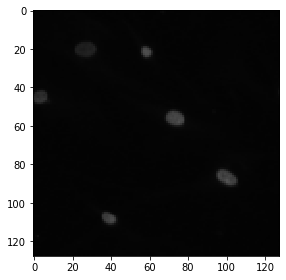

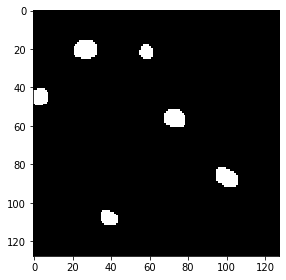

In [9]:
# Validating
X_train = np.load('NPY files/trainingNPYfiles/TrainingData.npy')
imageX = random.randint(0, len(train_ids))
imshow(X_train[imageX])
plt.show()

Y_train = np.load('NPY files/trainingNPYfiles/Masks.npy')
imshow(np.squeeze(Y_train[imageX]))
plt.show()

X_test = np.load('NPY files/testingNPYfiles/TestingData.npy')

In [10]:
# Building the U-net model
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)) # Defining the input layer
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) # Converting input pixels to floating values

c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1) # To prevent neural net from over fitting
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2) # To prevent neural net from over fitting
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3) # To prevent neural net from over fitting
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4) # To prevent neural net from over fitting
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5) # To prevent neural net from over fitting
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Decoding the layers
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6) # To prevent neural net from over fitting
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7) # To prevent neural net from over fitting
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8) # To prevent neural net from over fitting
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9) # To prevent neural net from over fitting
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
# Model Checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [12]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25,callbacks=callbacks)

Train on 603 samples, validate on 67 samples
Epoch 1/25
603/603 [==============================] - 27s 44ms/sample - loss: 0.6157 - accuracy: 0.7725 - val_loss: 0.5229 - val_accuracy: 0.8226
Epoch 2/25
603/603 [==============================] - 6s 10ms/sample - loss: 0.4068 - accuracy: 0.8164 - val_loss: 0.2905 - val_accuracy: 0.8636
Epoch 3/25
603/603 [==============================] - 6s 10ms/sample - loss: 0.2734 - accuracy: 0.8706 - val_loss: 0.1990 - val_accuracy: 0.9182
Epoch 4/25
603/603 [==============================] - 6s 10ms/sample - loss: 0.1915 - accuracy: 0.9284 - val_loss: 0.1528 - val_accuracy: 0.9399
Epoch 5/25
603/603 [==============================] - 6s 10ms/sample - loss: 0.1473 - accuracy: 0.9459 - val_loss: 0.1299 - val_accuracy: 0.9494
Epoch 6/25
603/603 [==============================] - 6s 10ms/sample - loss: 0.1301 - accuracy: 0.9507 - val_loss: 0.1224 - val_accuracy: 0.9531
Epoch 7/25
603/603 [==============================] - 6s 10ms/sample - loss: 0.1213 

In [13]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

65/65 [==============================] - 1s 14ms/sample


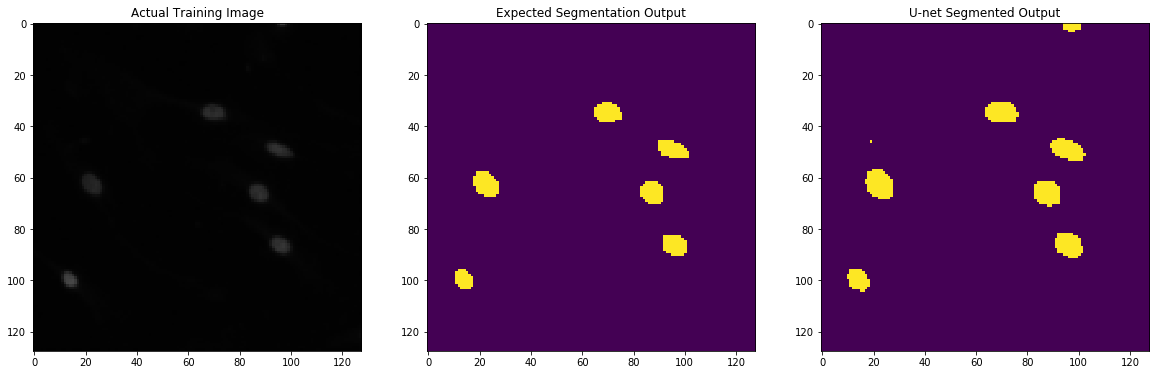

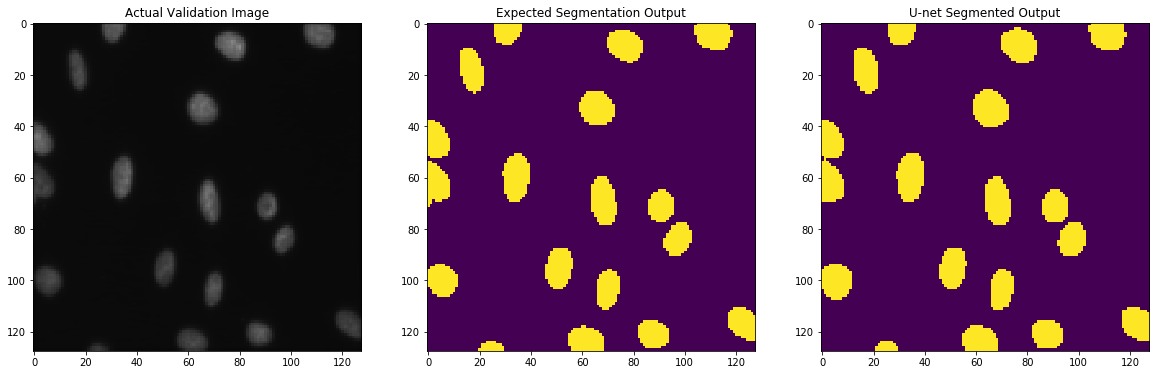

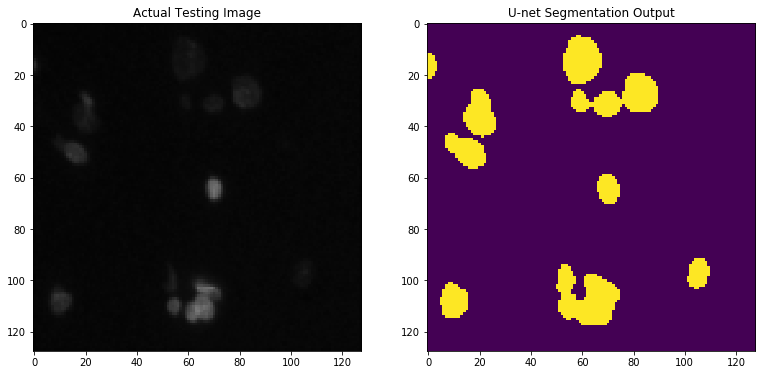

In [18]:
# ix = random.randint(0, len(preds_train_t))
# imshow(X_train[ix])
# plt.show()
# imshow(np.squeeze(Y_train[ix]))
# plt.show()
# imshow(np.squeeze(preds_train_t[ix]))
# plt.show()

ix = random.randint(0, len(preds_train_t))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_train[ix])
ax1.title.set_text('Actual Training Image')
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(np.squeeze(Y_train[ix]))
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('U-net Segmented Output')
ax3.imshow(np.squeeze(preds_train_t[ix]))


ix = random.randint(0, len(preds_val_t))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_train[int(X_train.shape[0]*0.9):][ix])
ax1.title.set_text('Actual Validation Image')
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('U-net Segmented Output')
ax3.imshow(np.squeeze(preds_val_t[ix]))

ix = random.randint(0, len(preds_test_t))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_test[ix])
ax1.title.set_text('Actual Testing Image')
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('U-net Segmentation Output')
ax2.imshow(np.squeeze(preds_test_t[ix]))


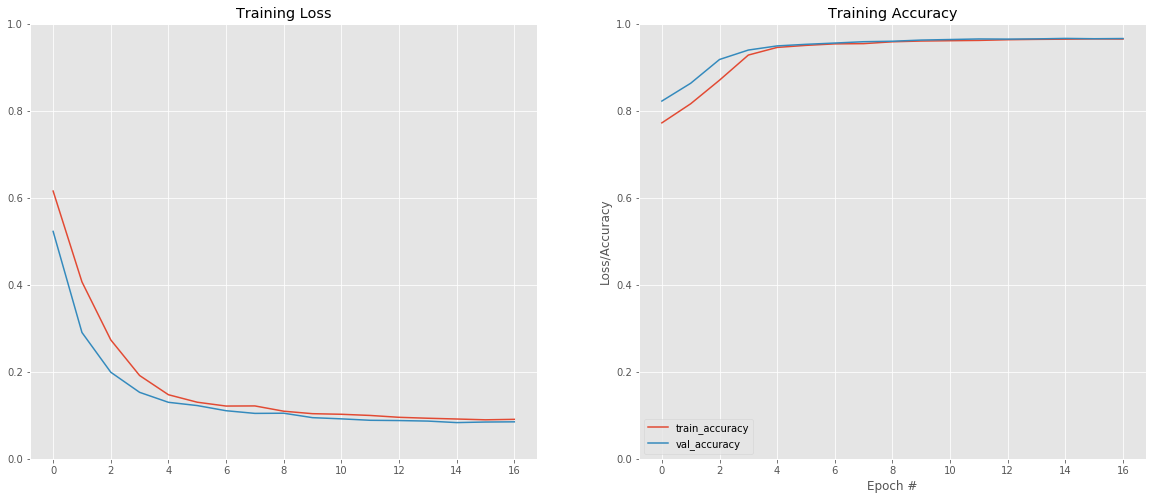

In [19]:
N = len(results.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), results.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), results.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [68]:
# Making a video out of input test images
make_video = False

if make_video:
      # This is done to individually compare the test output images with the test input images
#     for i in range(len(X_test)):
#         imshow(X_test[i])
#         plt.savefig('inputTestImages/input' + str(i) + '.jpg')
#         plt.show()
    
    out = cv2.VideoWriter('Output/video/inputVideo.avi',cv2.VideoWriter_fourcc(*'DIVX'), 0.8, (128, 128))

    for i in range(len(X_test)):
        out.write(X_test[i])
    out.release()

In [18]:
# Making a video out of output test images
make_video = False

if make_video:
    # Saving all the images in outputImages folder
    for i in range(len(preds_test_t)):
            imshow(np.squeeze(preds_test_t[i]))
            plt.savefig('Output/outputImages/output' + str(i) + '.jpg')
            plt.show()

    img_array = []
    for filename in glob.glob('Output/outputImages/*.jpg'):
        img = cv2.imread(filename)
        height, width, layers = img.shape
#         print(height, width, layers)
        size = (width,height)
        img_array.append(img)


    out = cv2.VideoWriter('Output/video/SegmentedOutput.avi',cv2.VideoWriter_fourcc(*'DIVX'), 0.8, (432,288))

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [ ]:
!tensorboard --logdir=logs/ --host localhost --port 8099